In [16]:
import matplotlib.pyplot as plt
import vaex
import os
import numpy as np
import pandas as pd
from helpers import *

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from helpers import *
import pandas as pd
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None  # default='warn'
## Parallel function to compute response function
from multiprocessing import Pool
import multiprocessing


### 1) Data Labelling
Assumption : a flash crash is defined as a price drop of more than 5% in a 30 minute window


In [63]:
# Data loading
current_dir  = os.getcwd()
loading_dir = os.path.join(current_dir,"data","clean", "flash_crash")
ticker_list = os.listdir(loading_dir)
if '.DS_Store' in ticker_list : ticker_list.remove('.DS_Store')
ticker_name =   ticker_list[1]
print("Ticker name: ", ticker_name)

plots_dir = os.path.join(current_dir,"plots","flash_crash",ticker_name)
file_dir = os.path.join(loading_dir,ticker_name)
file_name = os.listdir(file_dir)[0]
df = vaex.open(os.path.join(file_dir,file_name))

# Data cleaning 
df = df[ (df.index>= '2010-05-06') & (df.index<= '2010-05-30') ]
df = df.dropnan(column_names=["trade_price"])
df = df.to_pandas_df()
df.loc[:, ['bid-price', 'bid-volume','ask-price','ask-volume', ]] = df[['bid-price','bid-volume','ask-price','ask-volume']].ffill().fillna(method='bfill')

df["mid_price"] = (df["bid-price"] + df["ask-price"])/2
ny_index = pd.DatetimeIndex(df['index']) 
ny_index = ny_index.tz_localize('UTC').tz_convert('America/New_York')
df['ny_index'] = ny_index 
df.set_index('ny_index',drop=True,inplace=True)
df = df[ (df.index>= '2010-05-06 12:30') & (df.index<= '2010-05-30') ]
df

Ticker name:  AAPL.OQ-2010


,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume,index,mid_price
ny_index,,,,,,,,
2010-05-06 12:30:04.272999680-04:00,254.51,200.0,254.48,2.0,254.59,6.0,2010-05-06 16:30:04.272999680,254.535
2010-05-06 12:30:04.296999424-04:00,254.51,100.0,254.48,2.0,254.59,6.0,2010-05-06 16:30:04.296999424,254.535
2010-05-06 12:30:10.440000-04:00,254.51,200.0,254.48,2.0,254.59,6.0,2010-05-06 16:30:10.440000000,254.535
2010-05-06 12:30:10.644999936-04:00,254.51,100.0,254.48,2.0,254.59,6.0,2010-05-06 16:30:10.644999936,254.535
2010-05-06 12:30:13.690999552-04:00,254.51,600.0,254.50,3.0,254.59,2.0,2010-05-06 16:30:13.690999552,254.545
...,...,...,...,...,...,...,...,...
2010-05-28 15:59:59.159000064-04:00,257.00,1200.0,256.80,6.0,257.00,9.0,2010-05-28 19:59:59.159000064,256.900
2010-05-28 15:59:59.192000-04:00,257.00,200.0,256.80,6.0,257.00,7.0,2010-05-28 19:59:59.192000000,256.900
2010-05-28 15:59:59.299000064-04:00,256.86,500.0,256.80,6.0,257.00,7.0,2010-05-28 19:59:59.299000064,256.900


In [5]:
## TODO : Group trades into minutes by taking sum of trade volume, mean price.. and label as flash crash if the number of trades exceed the threshold within the window


,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume,index,mid_price,max_price_pct_change,min_price_pct_change,flash_crash
ny_index,,,,,,,,,,,
2010-05-06 09:30:01.898000128-04:00,254.005,200.0,253.99,5.0,254.01,1.0,2010-05-06 13:30:01.898000128,254.00,0.000000,0.000000,0
2010-05-06 09:30:01.909999616-04:00,254.130,100.0,253.99,5.0,254.01,1.0,2010-05-06 13:30:01.909999616,254.00,0.000000,0.000000,0
2010-05-06 09:30:01.952999936-04:00,254.195,200.0,254.00,1.0,254.24,2.0,2010-05-06 13:30:01.952999936,254.12,0.000472,-0.000472,0
2010-05-06 09:30:01.976000256-04:00,254.240,200.0,254.00,1.0,254.50,10.0,2010-05-06 13:30:01.976000256,254.25,0.000984,-0.000983,0
2010-05-06 09:30:02.060000-04:00,254.480,1200.0,254.00,1.0,254.70,3.0,2010-05-06 13:30:02.060000000,254.35,0.001378,-0.001376,0
...,...,...,...,...,...,...,...,...,...,...,...
2010-05-28 15:59:59.159000064-04:00,257.000,1200.0,256.80,6.0,257.00,9.0,2010-05-28 19:59:59.159000064,256.90,0.008666,-0.008591,0
2010-05-28 15:59:59.192000-04:00,257.000,200.0,256.80,6.0,257.00,7.0,2010-05-28 19:59:59.192000000,256.90,0.008666,-0.008591,0
2010-05-28 15:59:59.299000064-04:00,256.860,500.0,256.80,6.0,257.00,7.0,2010-05-28 19:59:59.299000064,256.90,0.008666,-0.008591,0


In [64]:
# Data Labelling
## Label as flash crash where the drop and recovery exceed the thresholds within the window
WINDOW = '1800s' # 30 minutes
PRICE_DROP_THRESHOLD = 0.05  # 5% price drop

def max_pct_change(series):
    if len(series) < 2:
        return 0
    return ((series.max() - series) / series).max()

def min_pct_change(series):
    if len(series) < 2:
        return 0
    return ((series.min() - series) / series).min()

# Calculate the rolling max and min percentage change for the 'mid_price' column
df['max_price_pct_change'] = df['mid_price'].rolling(WINDOW).apply(max_pct_change, raw=True)
df['min_price_pct_change'] = df['mid_price'].rolling(WINDOW).apply(min_pct_change, raw=True)
df['flash_crash'] = ((df['min_price_pct_change'] <= -PRICE_DROP_THRESHOLD) & (df['max_price_pct_change'] >= PRICE_DROP_THRESHOLD) ).astype(int)

print(df.groupby('flash_crash').count().iloc[:,0])
df[['max_price_pct_change','min_price_pct_change']].describe()

flash_crash
0    560192
1     20993
Name: trade_price, dtype: int64


,max_price_pct_change,min_price_pct_change
count,581185.000000,581185.000000
mean,0.016565,-0.015528
std,0.030973,0.025216
min,0.000000,-0.202884
25%,0.006790,-0.014536
50%,0.009666,-0.009573
75%,0.014751,-0.006744
max,0.254523,0.000000


### Parallel computation of R 
Note : As the response function takes a significant amount of time to process, we will perform it in parallel.

Text(0.5, 1.0, 'AAPL.OQ-2010 Response function')

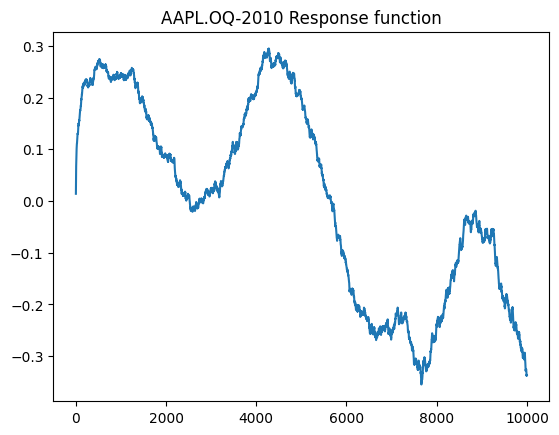

In [73]:
def compute_response_parallel(df, tau_max=100, num_processes=4):
    tau_values = range(1, tau_max)
    pool = Pool(processes=num_processes)
    results = pool.starmap(compute_response_tau, [(tau, df) for tau in tau_values])
    pool.close()
    pool.join()
    results.sort(key=lambda x: x[0])  # Sort results by tau
    R = [x[1] for x in results]
    R_std = [x[2] for x in results] 
    return R , R_std

# Example usage:
# Assuming you have a DataFrame df containing your data
num_cores = multiprocessing.cpu_count()
df_test  = df[(df.index >= '2010-05-06') & (df.index<='2010-05-07')].copy()
df_test = setup_response_function_data(df_test)
response_df,_ = compute_response_parallel(df_test, tau_max=10000, num_processes=num_cores)

plt.plot(response_df)
plt.title(ticker_name+ ' Response function')

Text(0.5, 1.0, 'AAPL.OQ-2010 Response function')

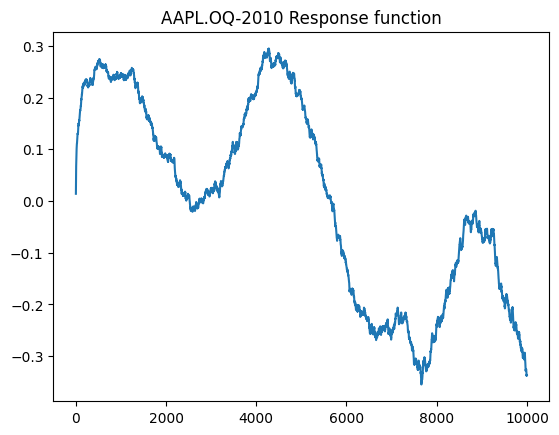

In [74]:
df_test  = df[(df.index >= '2010-05-06') & (df.index<='2010-05-07')].copy()
df_test = setup_response_function_data(df_test)
response_df, _ = compute_response(df_test, tau_max=10000)

plt.plot(response_df)
plt.title(ticker_name+ ' Response function')

We notice a one second gain in computation time with parallelization.
#### 2) Training 
Note: Training should be done on a rolling calibration.
We cannot just perform a logistic regresssion because the flash crash actually only happens a few times so with a rolling callibration, we will mostly have one class (0: non flash crash). We can either try to label our data with a probability of crash but this needs very stong assumptions about price volatility and other metrics. Or the method we will be implementing is using the market response function. First we need a regression on a the response function, then a classification using a simple model (exceeding a magnitude threshold in values/spread)

#### a) Naive approach : Use Mean squared error as loss function

In [79]:
# Parameters
k = 3000 # Window size
tau_max = k # should be equal to k
# tau_max = 5000  # Maximum lag
threshold = 0.5  # Threshold for deviation
num_cores = multiprocessing.cpu_count()
# Initialize model
model = LinearRegression()
def compute_deviation(y_pred, y_true):
    return ((y_pred - y_true)**2).mean()

# Fit and predict in a rolling window
for i in range(k, len(df)):
    # Fit the model on the window from t to t+k
    window = df[i-k:i-1]
    X_train = window
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['prev_mid_price','prev_trade'],inplace=True)
    y_train,_ = compute_response_parallel(window,tau_max,num_processes=num_cores)        # Response function
    na = np.isnan(y_train)
    y_train[-1] = y_train[-2]
    if not X_train.flash_crash.sum() : model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    # Calculate deviation
    deviation = compute_deviation(y_pred, y_train)

    # Check for flash crash
    print(f"Deviation at {df.index[i+1]}: {deviation}")
    if deviation > threshold:
        print(f"Flash crash predicted at time {df.index[i+1]}")
        print(f"Predicted response: {y_pred}")

Deviation at 2010-05-06 13:24:37.714999808-04:00: 0.061997022957179355
Flash crash predicted at time 2010-05-06 13:24:37.714999808-04:00
Predicted response: [0.11347632 0.11301818 0.11347632 ... 0.49838213 0.47243325 0.43433069]
Deviation at 2010-05-06 13:24:37.833999872-04:00: 0.06455248318544661
Flash crash predicted at time 2010-05-06 13:24:37.833999872-04:00
Predicted response: [0.1073562  0.10869962 0.1073562  ... 0.44163689 0.4067314  0.41971514]
Deviation at 2010-05-06 13:24:37.842999552-04:00: 0.06943576027724445
Flash crash predicted at time 2010-05-06 13:24:37.842999552-04:00
Predicted response: [0.10621421 0.10442537 0.13883913 ... 0.37652232 0.39223248 0.38675622]
Deviation at 2010-05-06 13:24:37.853999616-04:00: 0.07801591570141189
Flash crash predicted at time 2010-05-06 13:24:37.853999616-04:00
Predicted response: [0.10402842 0.13837682 0.13695948 ... 0.36046011 0.35727654 0.35213124]
Deviation at 2010-05-06 13:24:38.274000128-04:00: 0.09327198281933088
Flash crash predi

KeyboardInterrupt: 

#### b) Dynamic Time Warping (DTW):
DTW is a technique for measuring the similarity between two sequences, even when they have different lengths or are temporally misaligned. So we can use this function even when window and tau max are not equal

In [34]:
from fastdtw import fastdtw

# Parameters
k = 10000  # Window size
tau_max = k # should be equal to k
threshold = 400  # Threshold for deviation
num_cores = multiprocessing.cpu_count()
# Initialize model
model = LinearRegression()
def compute_deviation(y_pred, y_true):
    distance, _ = fastdtw(y_true, y_pred)
    return distance

# Fit and predict in a rolling window
for i in range(k, len(df)):
    # Fit the model on the window from t to t+k
    window = df[i-k:i-1]
    X_train = window
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['prev_mid_price','prev_trade'],inplace=True)
    y_train,_ = compute_response_parallel(window,tau_max,num_processes=num_cores)        # Response function
    na = np.isnan(y_train)
    y_train[-1] = y_train[-2]
    if not X_train.flash_crash.sum() : model.fit(X_train, y_train)    y_pred = model.predict(X_train)
    # Calculate deviation
    deviation = compute_deviation(y_pred, y_train)

    # Check for flash crash
    print(f"Deviation at {df.index[i+1]}: {deviation}")
    if deviation > threshold:
        print(f"Flash crash predicted at time {df.index[i+1]}")
        print(f"Predicted response: {y_pred}")

Deviation at 2010-05-06 11:30:39.536999680-04:00: 302.9197691416108
Deviation at 2010-05-06 11:30:39.547000064-04:00: 298.52384304707766
Deviation at 2010-05-06 11:30:39.566999808-04:00: 302.237032883221
Deviation at 2010-05-06 11:30:39.576000-04:00: 298.7572363203672
Deviation at 2010-05-06 11:30:39.595999744-04:00: 298.03388935206135
Deviation at 2010-05-06 11:30:39.625999872-04:00: 296.4400185778413
Deviation at 2010-05-06 11:30:39.982999808-04:00: 292.39858483302504
Deviation at 2010-05-06 11:30:40.579000320-04:00: 290.86421554673757


KeyboardInterrupt: 

#### c) Kernel Density Estimation (KDE)

In [77]:
from scipy.stats import wasserstein_distance
from sklearn.neighbors import KernelDensity

def compute_deviation(y_pred, y_true):
    # Assuming actual_response and predicted_response are your time series data
    kde_actual = KernelDensity(kernel='gaussian').fit(np.array(y_true).reshape(-1, 1))
    kde_predicted = KernelDensity(kernel='gaussian').fit(np.array(y_pred).reshape(-1, 1))
    # Evaluate the estimated density functions on a grid
    x_grid = np.linspace(min(min(y_true), min(y_pred)),
                        max(max(y_true), max(y_pred)), 1000)
    log_density_actual = kde_actual.score_samples(x_grid.reshape(-1, 1))
    log_density_predicted = kde_predicted.score_samples(x_grid.reshape(-1, 1))
    # Calculate the Wasserstein distance between the two estimated distributions
    distance = wasserstein_distance(np.exp(log_density_actual), np.exp(log_density_predicted))
    return distance

# Parameters
k = 10000  # Window size
tau_max = k # should be equal to k
threshold = 0.01  # Threshold for deviation
num_cores = multiprocessing.cpu_count()
# Initialize model
model = LinearRegression()

# Fit and predict in a rolling window
for i in range(k, len(df)):
    # Fit the model on the window from t to t+k
    window = df[i-k:i-1]
    X_train = window
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['prev_mid_price','prev_trade'],inplace=True)
    y_train,_ = compute_response_parallel(window,tau_max,num_processes=num_cores)        # Response function
    na = np.isnan(y_train)
    y_train[-1] = y_train[-2]
    if not X_train.flash_crash.sum() : model.fit(X_train, y_train)   
    y_pred = model.predict(X_train)
    # Calculate deviation
    deviation = compute_deviation(y_pred, y_train)

    # Check for flash crash
    print(f"Deviation at {df.index[i+1]}: {deviation}")
    if deviation > threshold:
        print(f"Flash crash predicted at time {df.index[i+1]}")
        print(f"Predicted response: {y_pred}")

Deviation at 2010-05-06 14:36:56.721999872-04:00: 0.0016404373379223195
Deviation at 2010-05-06 14:36:57.056999936-04:00: 0.001801835079396319
Deviation at 2010-05-06 14:36:57.086999296-04:00: 0.0019718751873947587
Deviation at 2010-05-06 14:36:57.139999488-04:00: 0.002150699117435091
Deviation at 2010-05-06 14:36:57.315999488-04:00: 0.0023130834015002467
Deviation at 2010-05-06 14:36:57.392999424-04:00: 0.002196006062763292
Deviation at 2010-05-06 14:36:57.426999552-04:00: 0.002069681382201596
Deviation at 2010-05-06 14:36:57.702999552-04:00: 0.0019404673257341516
Deviation at 2010-05-06 14:36:57.830999296-04:00: 0.001815981925774883
Deviation at 2010-05-06 14:36:57.878999296-04:00: 0.0016931318018671055
Deviation at 2010-05-06 14:36:58.006999808-04:00: 0.0015697390348948638
Deviation at 2010-05-06 14:36:58.100000-04:00: 0.0014621006759427207
Deviation at 2010-05-06 14:36:58.148000-04:00: 0.0013960679351054353
Deviation at 2010-05-06 14:36:58.198999808-04:00: 0.0014410686968614292
Dev

KeyboardInterrupt: 

#### d) Analytical observations from the response function
- Magnitude of the Response Function
- Volatility of the Response Function
- Stability of the Response Function

In [75]:
from scipy.stats import ttest_ind, ranksums

def compute_deviation(y_pred, y_true, weight_ttest=1.0, weight_volatility=1.0, weight_stability=1.0):
    # Response magnitude
    t_stat, p_value_t = ttest_ind(y_pred, y_true,alternative='less')
    U_stat, p_value_u = ranksums(y_pred, y_true,alternative='less')

    # Volatility
    y_pred_volatility = np.std(y_pred)
    y_true_volatility = np.std(y_true)
    
    # Stability of response function
    cv_true = np.std(y_true) / np.mean(y_true)
    cv_pred = np.std(y_pred) / np.mean(y_pred)
    
    # Calculate individual deviations
    deviation_ttest = (p_value_t < 0.05) * weight_ttest
    deviation_volatility = (y_pred_volatility > y_true_volatility) * weight_volatility
    deviation_stability = (cv_pred > cv_true) * weight_stability
    
    # Calculate the overall deviation
    overall_deviation = deviation_ttest + deviation_volatility + deviation_stability
    
    return overall_deviation

# Parameters
k = 1000  # Window size
tau_max = k # should be equal to k
threshold = 0.01  # Threshold for deviation
num_cores = multiprocessing.cpu_count()
# Initialize model
model = LinearRegression()

# Fit and predict in a rolling window
for i in range(k, len(df)):
    # Fit the model on the window from t to t+k
    window = df[i-k:i-1]
    X_train = window
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['prev_mid_price','prev_trade'],inplace=True)
    y_train,_ = compute_response_parallel(window,tau_max,num_processes=num_cores)        # Response function
    na = np.isnan(y_train)
    y_train[-1] = y_train[-2]
    if not X_train.flash_crash.sum() : model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    # Calculate deviation
    p_value_t, p_value_u = compute_deviation(y_pred, y_train)

    # Check for flash crash
    print(f"Deviation at {df.index[i+1]}: {p_value_t<0.05}, {p_value_u<0.05}")
    if deviation > threshold:
        print(f"Flash crash predicted at time {df.index[i+1]}")
        print(f"Predicted response: {y_pred}")



TypeError: cannot unpack non-iterable numpy.float64 object